In [580]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [581]:
# which outbreaks were the most severe?
# which outbreaks caused the most number of people to be ill?
# which outbreaks caused the most number of hospitalizations?
# which outbreaks caused a disproportionate number of hospitalizations per illness? fatalities?

In [582]:
df = pd.read_csv('outbreaks.csv')

In [583]:
df = df[df['Food'].notnull()][df['Species'].notnull()]

/home/jackdougherty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [584]:
df.head()

,Year,Month,State,Location,Food,Ingredient,Species,Serotype/Genotype,Status,Illnesses,Hospitalizations,Fatalities
3,1998,January,California,Restaurant,"Fish, Ahi",NaN,Scombroid toxin,NaN,Confirmed,4,0.0,0.0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",NaN,Salmonella enterica,Enteritidis,Confirmed,26,3.0,0.0
7,1998,January,California,Restaurant,"Stuffing, Unspecified; Sandwich, Turkey",NaN,Salmonella enterica,Enteritidis,Confirmed,4,3.0,0.0
8,1998,January,Colorado,Restaurant,"Salad, Unspecified",NaN,Virus,NaN,Suspected,21,NaN,NaN
9,1998,January,Colorado,Restaurant,"Peppers, Chili",NaN,Virus,NaN,Suspected,3,NaN,0.0


In [585]:
food_set = df['Food'].str.lower().str.replace(',','').str.replace(';','').str.split()
food_set.head()

3                                  [fish, ahi]
4          [lasagna, unspecified, eggs, other]
7    [stuffing, unspecified, sandwich, turkey]
8                         [salad, unspecified]
9                             [peppers, chili]
Name: Food, dtype: object

In [586]:
species_set = df['Species'].str.lower().str.replace(';',',').str.split(',').map(lambda x:[i.strip() for i in x])
species_set.head()

3        [scombroid toxin]
4    [salmonella enterica]
7    [salmonella enterica]
8                  [virus]
9                  [virus]
Name: Species, dtype: object

In [587]:
df['clean food'] = food_set

In [588]:
df['clean species'] = species_set

In [589]:
# one challenge with this data was that some, but not most, of the outbreaks had multiple species
# reported, but these reports were inconsistent. Some of the secondary species were subtypes of the
# first species listed, and some secondary species were separate organisms altogether, which could be a 
# sign of inaccurate data due to the fact that polymicrobial infections are relatively uncommon; more likely, one
# or more of the species reported in polymicrobial infections were misreported contaminants

In [590]:
# the following block of code shows that 672 outbreaks out 7245 had multiple species report, and the 
# majority of those were subtypes rather than secondary organisms

In [591]:
df[df['clean species'].apply(len)>1]['clean species']

137      [clostridium perfringens, staphylococcus aureus]
370                    [shigella boydii, shigella sonnei]
469             [escherichia coli, shiga toxin-producing]
474                  [escherichia coli, enteropathogenic]
506             [escherichia coli, shiga toxin-producing]
                               ...                       
18983     [norovirus genogroup i, norovirus genogroup ii]
19012           [escherichia coli, shiga toxin-producing]
19038            [bacillus cereus, staphylococcus aureus]
19080           [escherichia coli, shiga toxin-producing]
19095            [bacillus cereus, staphylococcus aureus]
Name: clean species, Length: 672, dtype: object

In [592]:
# adding a column to df that takes the first species from reported list

In [593]:
df['primary species'] = df['clean species'].apply(lambda x: x[0])

In [594]:
# using the primary species to one-hot encode the outbreaks, which turns out to be unncessary, and 
# further down in the notebook you will see groupby accomplish the same task with less code and computation

In [595]:
pd.get_dummies(df['primary species']).head(2)

,amnesic shellfish poison,anisakis,bacillus cereus,bacillus other,bacillus unknown,bacterium,brucella unknown,campylobacter,campylobacter coli,campylobacter jejuni,...,trichinella spiralis,trichinella unknown,unknown,vibrio cholerae,vibrio other,vibrio parahaemolyticus,vibrio unknown,vibrio vulnificus,virus,yersinia enterocolitica
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [596]:
df['Illnesses'].values.reshape(-1,1)

array([[ 4],
       [26],
       [ 4],
       ...,
       [10],
       [29],
       [16]])

In [597]:
illness_counts_dummies = pd.get_dummies(df['primary species']) * df['Illnesses'].values.reshape(-1,1)

In [598]:
df_illnesses = pd.merge(df, illness_counts_dummies, left_index=True, right_index=True)

In [599]:
# df.groupby('primary species').sum().iloc[:40,:]

In [600]:
# df.groupby('primary species').sum().iloc[40:,:]

In [601]:
illnesses = df.groupby('primary species').sum()['Illnesses']
top_illnesses = illnesses.sort_values(ascending=False)

In [602]:
# top_illnesses[:10]

In [603]:
hospitalizations = df.groupby('primary species').sum()['Hospitalizations']
top_hospitalizations = hospitalizations.sort_values(ascending=False)

In [604]:
# top_hospitalizations[:10]

In [605]:
fatalities = df.groupby('primary species').sum()['Fatalities']
top_fatalities = fatalities.sort_values(ascending=False)

In [606]:
# top_fatalities[:10]

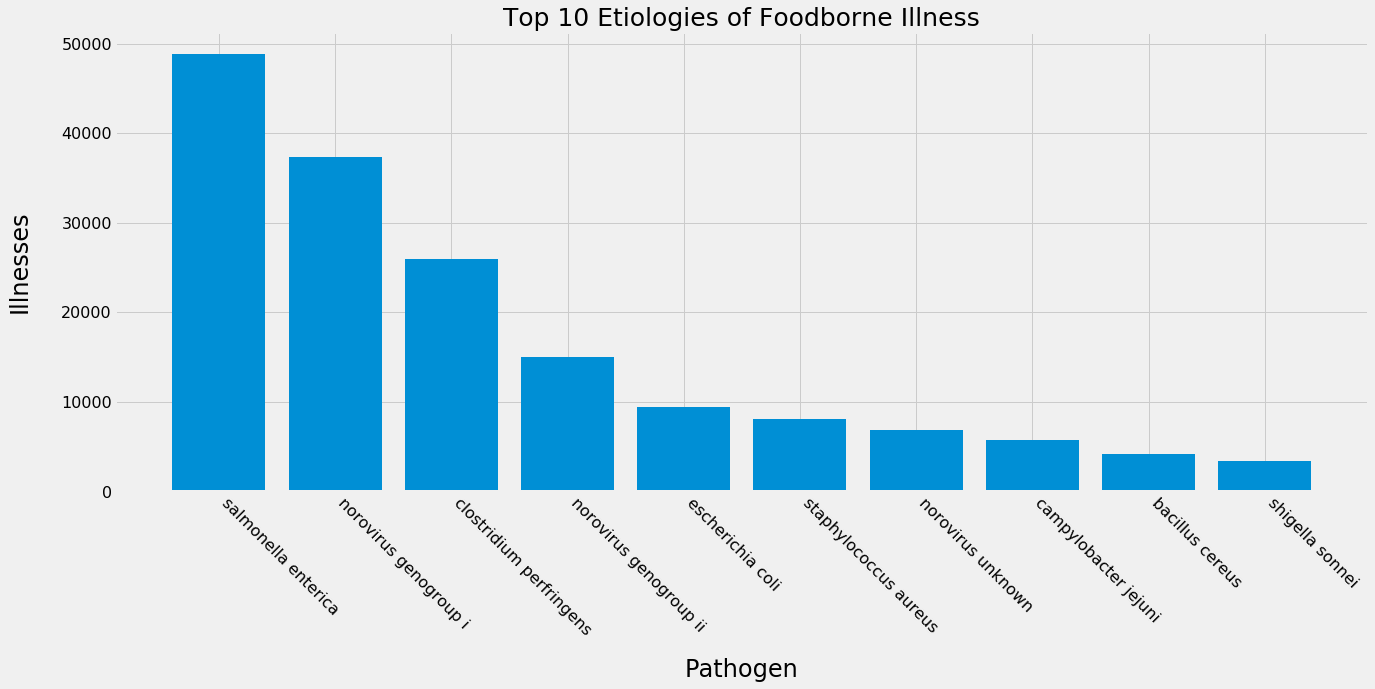

In [656]:
top = top_illnesses

fig,ax = plt.subplots(figsize=(20,11))
ax.bar(top[:10].index,top[:10])
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=24)
ax.set_ylabel('Illnesses', fontsize=24, labelpad = 30)
ax.set_title('Top 10 Etiologies of Foodborne Illness', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-45, ha='left')
plt.yticks(fontsize=16)
plt.tight_layout
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('figures/etiologies');

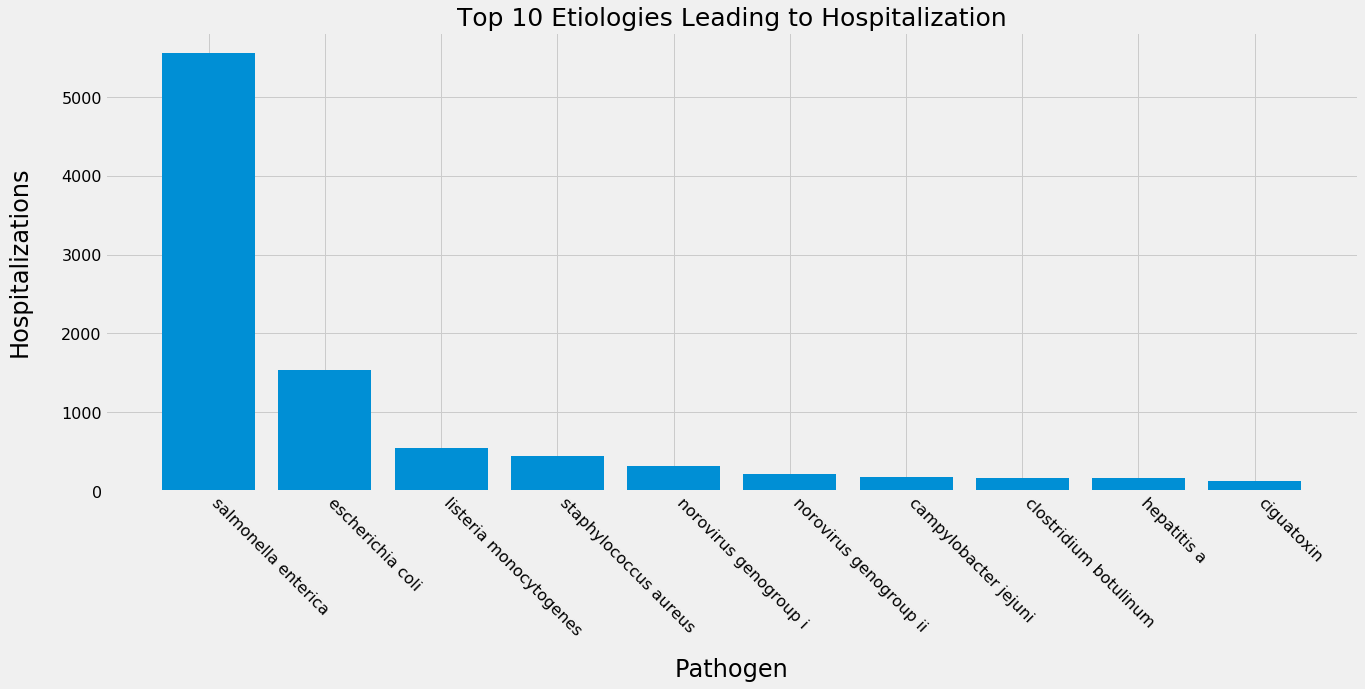

In [659]:
top = top_hospitalizations

fig,ax = plt.subplots(figsize=(20,11))
ax.bar(top[:10].index,top[:10])
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=24)
ax.set_ylabel('Hospitalizations', fontsize=24, labelpad = 30)
ax.set_title('Top 10 Etiologies Leading to Hospitalization', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-45, ha='left')
plt.yticks(fontsize=16)
plt.tight_layout
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('figures/hospitalizations');

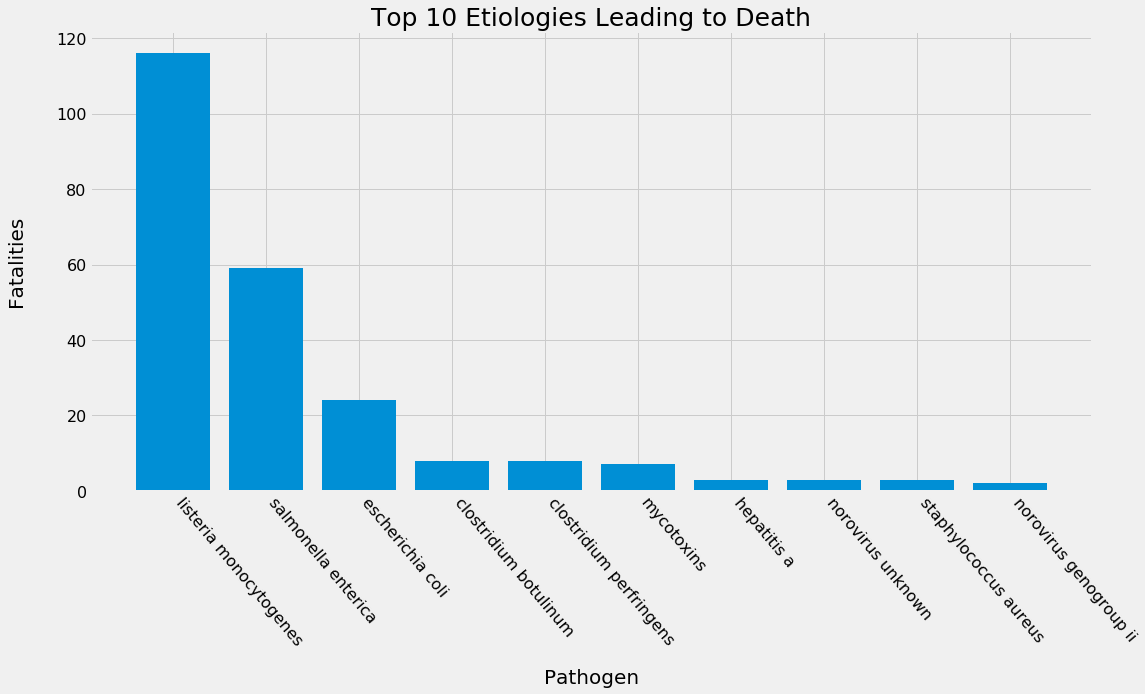

In [681]:
top = top_fatalities

fig,ax = plt.subplots(figsize=(16,11))
ax.bar(top[:10].index,top[:10])
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=20)
ax.set_ylabel('Fatalities', fontsize=20, labelpad = 30)
ax.set_title('Top 10 Etiologies Leading to Death', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-50, ha='left')
plt.yticks(fontsize=16)
plt.gcf().subplots_adjust(bottom=0.30)
plt.tight_layout
plt.savefig('figures/fatalities');

In [610]:
# fig,axs = plt.subplots(3,1, figsize=(20,20))

# axs[0].bar(top_illnesses[:10].index,top_illnesses[:10])
# axs[0].set_title('Cases', fontsize=35)

# axs[1].bar(top_hospitalizations[:10].index,top_hospitalizations[:10])
# axs[1].set_title('Hospitalizations', fontsize=35)

# axs[2].bar(top_fatalities[:10].index,top_fatalities[:10])
# axs[2].set_title('Fatalities', fontsize=35)

# axs[0].set_xticklabels(labels=top_illnesses[:10].index, rotation=-45)
# axs[1].set_xticklabels(labels=top_hospitalizations[:10].index, rotation=-45)
# axs[2].set_xticklabels(labels=top_fatalities[:10].index, rotation=-45)

# plt.setp(ax.xaxis.get_majorticklabels(), ha='left')

# plt.rc('xtick', labelsize=18) 
# plt.suptitle('Top 10 Etiologies of Foodborne Illnesses', size=40, verticalalignment='bottom')
# plt.subplots_adjust(hspace=0.7)
# plt.style.use('fivethirtyeight')
# plt.savefig('figures/etiologies');

In [611]:
hospitalizations_per_illness = hospitalizations / illnesses
top_hospitalizations_per_illness = hospitalizations_per_illness.sort_values(ascending=False)

In [612]:
fatalities_per_hospitalization = fatalities / hospitalizations
top_fatalities_per_hospitalization = fatalities_per_hospitalization.sort_values(ascending=False)

In [613]:
# There were only 2 cases of amnesic shellfish poissoning, and both resulted in hospitalization, with zero
# fatalities

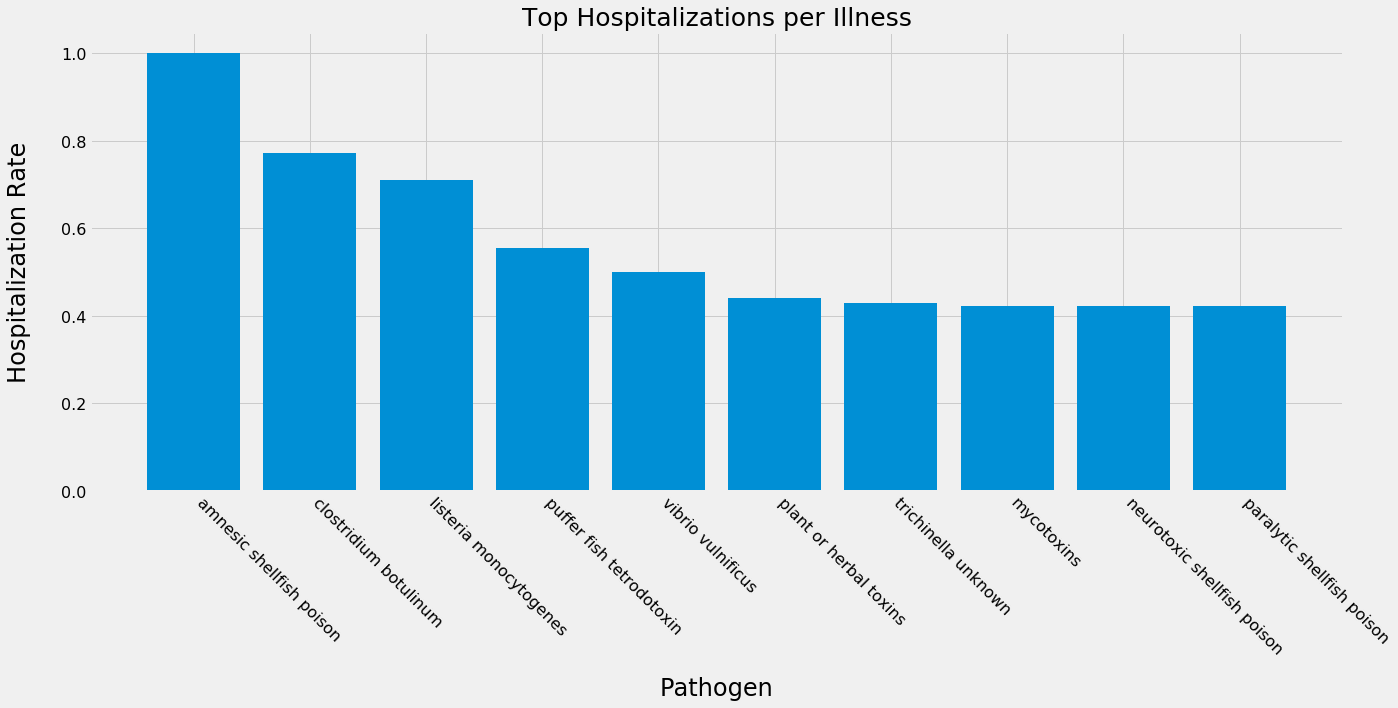

In [661]:
top = top_hospitalizations_per_illness

fig,ax = plt.subplots(figsize=(20,11))
ax.bar(top[:10].index,top[:10])
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=24)
ax.set_ylabel('Hospitalization Rate', fontsize=24, labelpad = 30)
ax.set_title('Top Hospitalizations per Illness', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-45, ha='left')
plt.yticks(fontsize=16)
plt.tight_layout
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('figures/hospitalizations_per_illness');

In [615]:
# Two cases of vibro vulnificus, one patient was hospitalized and died, the other patient was not hospitalized
# 762 cases of listeria, 541 hospitalizations, 116 deaths

In [616]:
# Extra filter for etiologies with >n illnesses

In [617]:
n = 2
df1 = df.groupby('primary species').sum()
illnesses1 = df1[df1['Illnesses'] > n]['Illnesses']
hospitalizations1 = df1[df1['Illnesses'] > n]['Hospitalizations']
fatalities1 = df1[df1['Illnesses'] > n]['Fatalities']

In [618]:
fatalities_per_illness1 = fatalities1 / illnesses1
top_fatalities_per_illness1 = fatalities_per_illness1.sort_values(ascending=False)

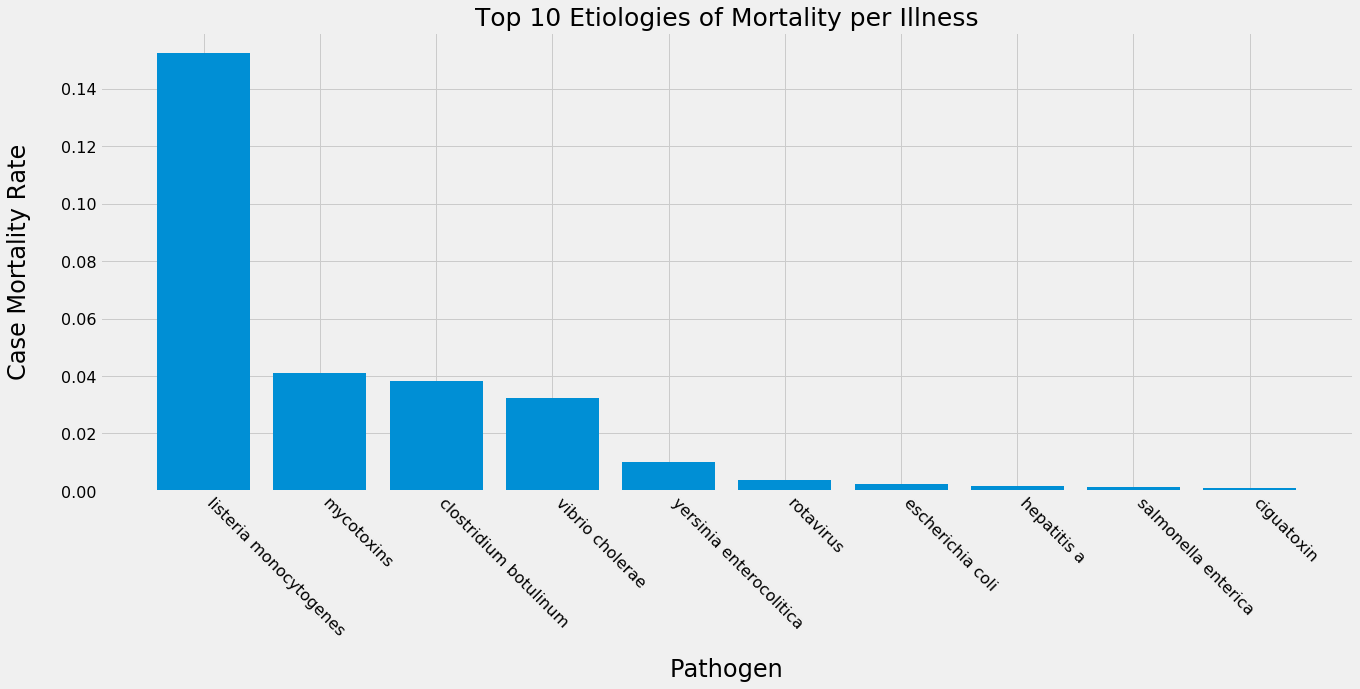

In [662]:
top = top_fatalities_per_illness1

fig,ax = plt.subplots(figsize=(20,11))
ax.bar(top[:10].index,top[:10])
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=24)
ax.set_ylabel('Case Mortality Rate', fontsize=24, labelpad = 30)
ax.set_title('Top 10 Etiologies of Mortality per Illness', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-45, ha='left')
plt.yticks(fontsize=16)
plt.tight_layout
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('figures/mortality_per_illness');

In [620]:
fatalities_per_hospitalization1 = fatalities1 / hospitalizations1
top_fatalities_per_hospitalization1 = fatalities_per_hospitalization1.sort_values(ascending=False)

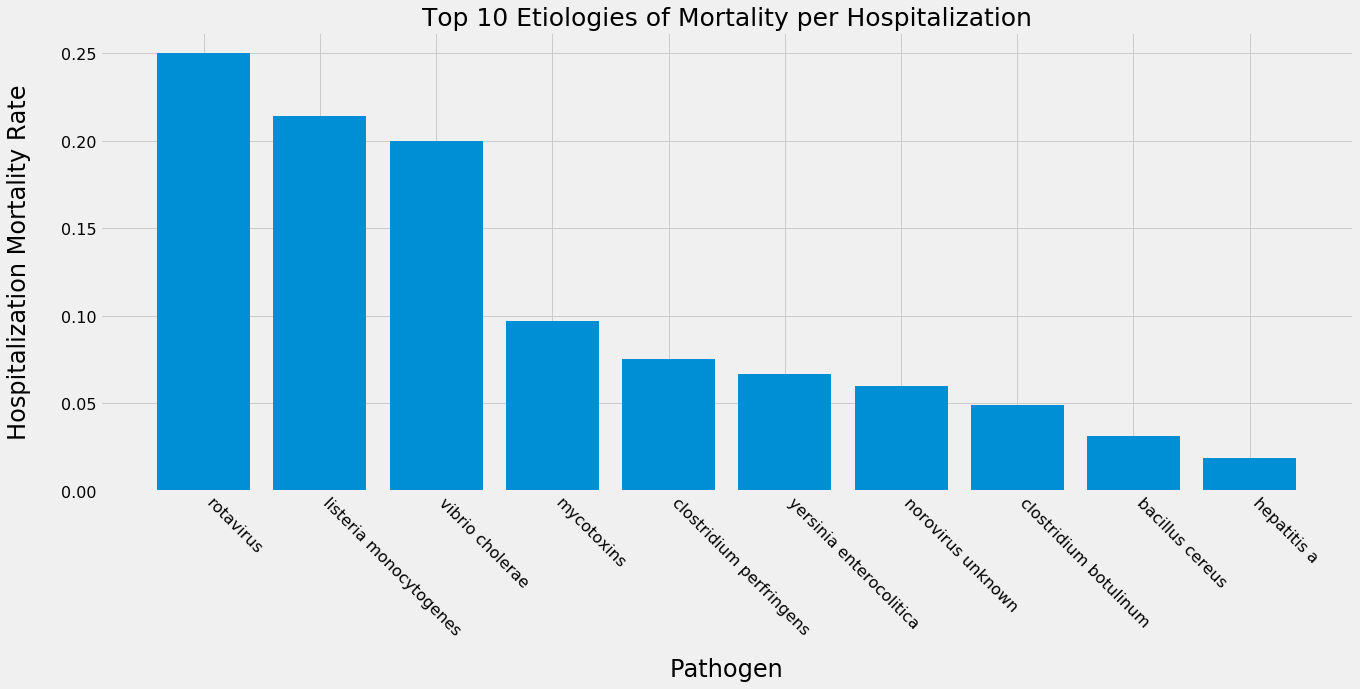

In [663]:
top = top_fatalities_per_hospitalization1

fig,ax = plt.subplots(figsize=(20,11))
ax.bar(top[:10].index,top[:10])
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=24)
ax.set_ylabel('Hospitalization Mortality Rate', fontsize=24, labelpad = 30)
ax.set_title('Top 10 Etiologies of Mortality per Hospitalization', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-45, ha='left')
plt.yticks(fontsize=16)
plt.tight_layout
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('figures/mortality_per_hospitalization');

In [622]:
# Fatalities per illness and fatalities per hospitalization among top 10 etiologies leading to hospitalization

In [623]:
fatalities_illness_hospital = fatalities_per_illness[top_hospitalizations.index[:10]]
fatalities_hospital_hospital = fatalities_per_hospitalization[top_hospitalizations.index[:10]]

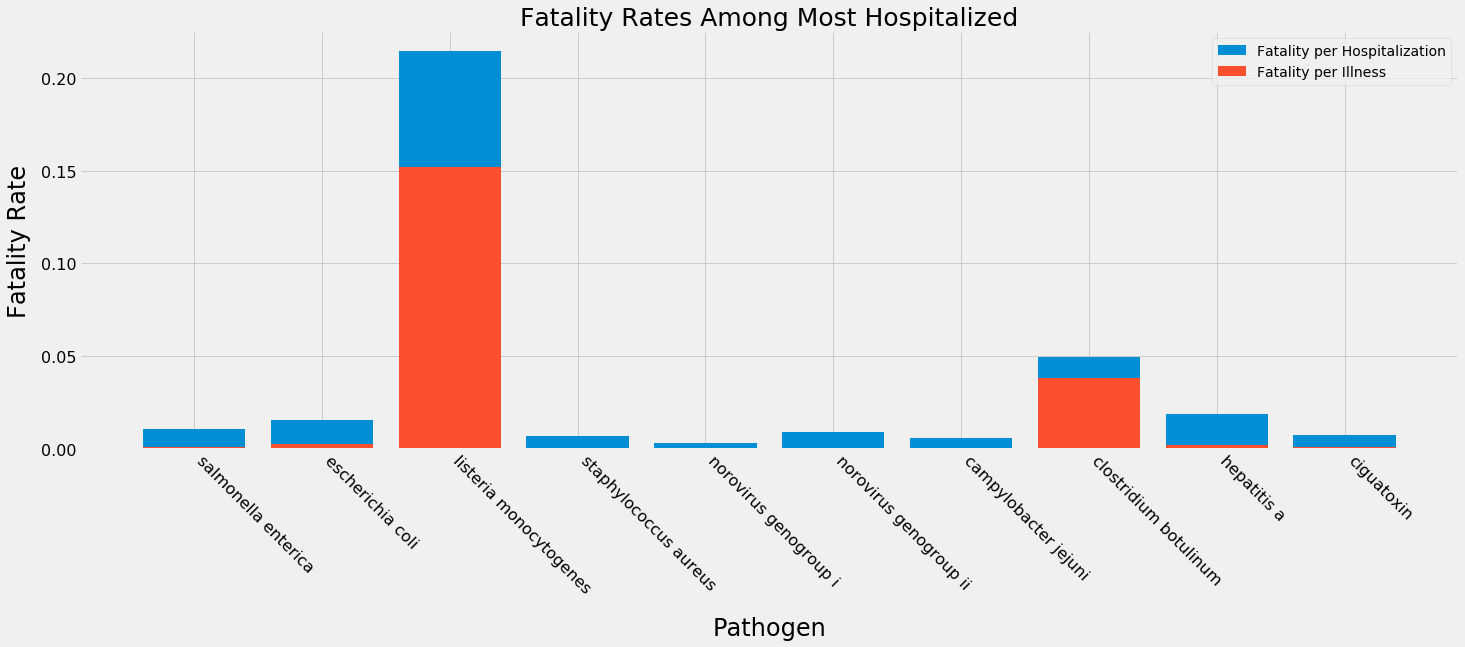

In [680]:
top = fatalities_illness_hospital

fig,ax = plt.subplots(figsize=(22, 10))
ax.bar(fatalities_hospital_hospital[:10].index,fatalities_hospital_hospital[:10], label='Fatality per Hospitalization')
ax.bar(fatalities_illness_hospital[:10].index,fatalities_illness_hospital[:10], label='Fatality per Illness')
ax.set_xlabel('Pathogen', labelpad = 20, fontsize=24)
ax.set_ylabel('Fatality Rate', fontsize=24, labelpad = 10)
ax.set_title('Fatality Rates Among Most Hospitalized', fontsize=25)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16, rotation=-45, ha='left')
plt.yticks(fontsize=16)
plt.gcf().subplots_adjust(bottom=0.30)
plt.legend()
plt.savefig('figures/fatality_rates_among_hospitalized')
plt.tight_layout;